# 使用keras架构实现mnist手写体数字识别

In [35]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

随便显示一个图片

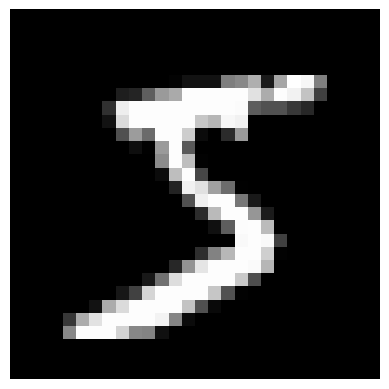

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 假设mnist_sample是一个(28, 28)的数组
mnist_sample = x_train[0]

plt.imshow(mnist_sample, cmap='gray')
plt.axis('off')
plt.show()


model

In [37]:
import keras
from keras.layers import *
from keras.models import Sequential

def residual_blocks(num_filter,input):
    conv1 = Conv2D(filters=num_filter, kernel_size=(2, 2), strides=1, padding='same')(input)
    bn1 = BatchNormalization(axis=-1)(conv1)
    conv2 = Conv2D(filters=num_filter, kernel_size=(2, 2), strides=1, padding='same')(bn1)
    bn2 = BatchNormalization(axis=-1)(conv2)
    conv3 = Conv2D(filters=num_filter, kernel_size=(2, 2), strides=1, padding='same')(bn2)
    bn3 = BatchNormalization(axis=-1)(conv3)
    res=concatenate([input,bn3],axis=-1)
    return res

def resnet_small(input_shape=(28,28,1),classes=10):
    X_input = Input(input_shape)
    #0填充
    X = ZeroPadding2D((2,2))(X_input)

    res1=residual_blocks(num_filter=6,input=X)

    pool2=MaxPooling2D(strides=2)(res1)
    res2=residual_blocks(num_filter=16,input=pool2)

    pool3=MaxPool2D(strides=2)(res2)
    linear=Flatten()(pool3)
    dense1=Dense(64,activation='relu')(linear)
    out=Dense(classes,activation='softmax')(dense1)
    model=keras.Model(inputs=X_input,outputs=out,name='resnet_small')
    return model
model=resnet_small()
model.summary()

Model: "resnet_small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 32, 32, 1)            0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_36 (Conv2D)          (None, 32, 32, 6)            30        ['zero_padding2d_4[0][0]']    
                                                                                                  
 batch_normalization_36 (Ba  (None, 32, 32, 6)            24        ['conv2d_36[0][0]']

In [38]:
def resnet_large(input_shape=(28,28,1),classes=10):
    X_input = Input(input_shape)
    #0填充
    X = ZeroPadding2D((2,2))(X_input)

    res1=residual_blocks(num_filter=6,input=X)

    pool2=MaxPooling2D(strides=2)(res1)
    res2=residual_blocks(num_filter=16,input=pool2)

    pool3=MaxPooling2D(strides=2)(res2)
    res3=residual_blocks(num_filter=32,input=pool3)

    pool4=MaxPooling2D(strides=2)(res3)
    res4=residual_blocks(num_filter=64,input=pool4)

    pool5=MaxPool2D(strides=2)(res4)
    linear=Flatten()(pool5)
    dense1=Dense(64,activation='relu')(linear)
    out=Dense(classes,activation='softmax')(dense1)
    model=keras.Model(inputs=X_input,outputs=out,name='resnet_large')
    return model
model_l=resnet_large()
model_l.summary()

Model: "resnet_large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d_5 (ZeroPadd  (None, 32, 32, 1)            0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 32, 6)            30        ['zero_padding2d_5[0][0]']    
                                                                                                  
 batch_normalization_42 (Ba  (None, 32, 32, 6)            24        ['conv2d_42[0][0]']

In [39]:
from keras.utils import to_categorical
y_train_cat=to_categorical(y_train,num_classes=10)
y_test_cat=to_categorical(y_test,num_classes=10)

In [40]:
print(y_train[0])
y_train_cat[0]
type(y_test_cat)

5


numpy.ndarray

In [41]:
x_test.shape[0]

10000

In [42]:
import random
class LossHistory(keras.callbacks.Callback):
    def __init__(self,batchsize):
        super().__init__()
        self.losses = []
        self.accs=[]
        self.val_losses=[]
        self.val_accs=[]
        self.x_test = x_test
        self.y_test = y_test_cat
        # print(batch)
        self.batch_size = batchsize

    def on_batch_end(self, batch, logs={}):
        indices = random.sample(range(10000), self.batch_size)
        x_batch = self.x_test[indices]
        y_batch = self.y_test[indices]
        val_loss, val_acc = self.model.evaluate(x_batch, y_batch, verbose=0)
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_l.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

bs=128
callback = LossHistory(batchsize=bs)
callback_l = LossHistory(batchsize=bs)

# 训练模型
history_small = model.fit(
    x_train, y_train_cat,
    epochs=1,
    batch_size=bs,
    verbose=1,
    callbacks=[callback]
)
history_large = model_l.fit(
    x_train, y_train_cat,
    epochs=1,
    batch_size=bs,
    verbose=1,
    callbacks=[callback_l]
)

469/469 [==============================] - 209s 438ms/step - loss: 0.2820 - accuracy: 0.9297


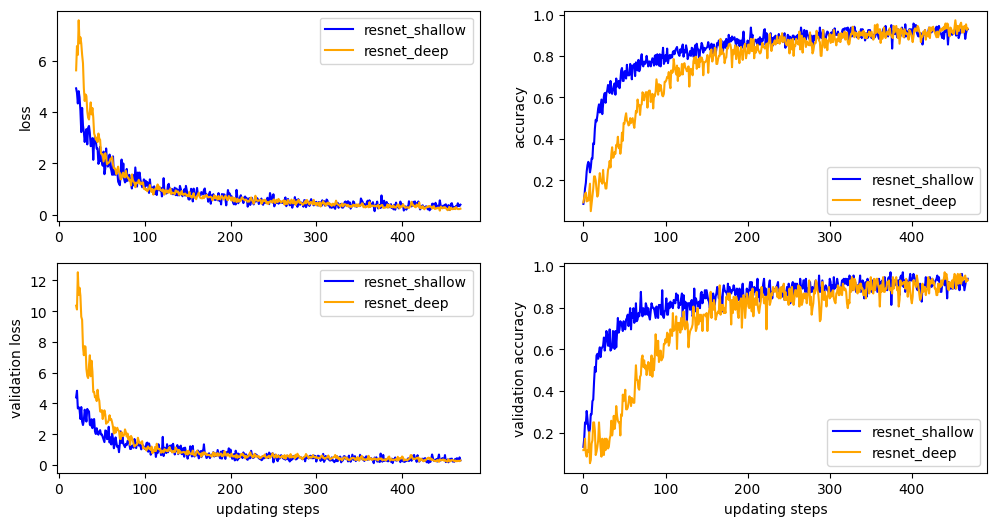

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# 假设A类和B类的列表如下


B_losses = [2, 3, 4, 5, 6]
B_accs = [0.5, 0.6, 0.7, 0.8, 0.9]
B_val_losses = [2.1, 2.9, 4.2, 4.8, 6.1]
B_val_accs = [0.4, 0.5, 0.6, 0.7, 0.8]


updating_steps_loss = range(20,len(callback.losses))
updating_steps = range(len(callback.losses))

# 计算曲线拟合的参数
# A_losses_fit = np.polyfit(updating_steps, callback.losses, deg=3)
# A_val_losses_fit = np.polyfit(updating_steps, callback.val_losses, 3)
# A_accs_fit = np.polyfit(updating_steps, callback.accs, 3)
# A_val_accs_fit = np.polyfit(updating_steps, callback.val_accs, 3)

# B_losses_fit = np.polyfit(updating_steps, callback_l.losses, 1)
# B_val_losses_fit = np.polyfit(updating_steps, callback_l.val_losses, 1)
# B_accs_fit = np.polyfit(updating_steps, callback_l.accs, 1)
# B_val_accs_fit = np.polyfit(updating_steps, callback_l.val_accs, 1)

# 绘制图表
plt.figure(figsize=(12, 6))

# losses和val_losses
plt.subplot(221)
plt.plot(updating_steps_loss, callback.losses[20:], label='resnet_shallow', color='blue')
plt.plot(updating_steps_loss,callback_l.losses[20:],label='resnet_deep', color='orange')
# plt.xlabel('updating steps')
plt.ylabel('loss')
plt.legend()

# accs和val_accs
plt.subplot(222)
plt.plot(updating_steps,callback.accs, label='resnet_shallow', color='blue')
plt.plot(updating_steps,callback_l.accs, label='resnet_deep', color='orange')
# plt.xlabel('updating steps')
plt.ylabel('accuracy')
plt.legend()


# losses和val_losses
plt.subplot(223)
plt.plot(updating_steps_loss, callback.val_losses[20:], label='resnet_shallow', color='blue')
plt.plot(updating_steps_loss,callback_l.val_losses[20:],label='resnet_deep', color='orange')
plt.xlabel('updating steps')
plt.ylabel('validation loss')
plt.legend()

# accs和val_accs
plt.subplot(224)
plt.plot(updating_steps,callback.val_accs, label='resnet_shallow', color='blue')
plt.plot(updating_steps,callback_l.val_accs, label='resnet_deep', color='orange')
plt.xlabel('updating steps')
plt.ylabel('validation accuracy')
plt.legend()

plt.show()
# plt.savefig('output_bs128.png')


测试集上的准确率

In [44]:
from sklearn.metrics import classification_report
predictions=model.predict(x_test,batch_size=1)
predictions_l=model_l.predict(x_test,batch_size=1)

10000/10000 [==============================] - 22s 2ms/step


In [45]:
shallow_repo=classification_report(y_test,predictions.argmax(axis=-1),target_names=['0','1','2','3','4','5','6','7','8','9'])
deep_repo=classification_report(y_test,predictions_l.argmax(axis=-1),target_names=['0','1','2','3','4','5','6','7','8','9'])
with open('bs128.txt','w')as f:
    print('shallow:\n',shallow_repo,file=f)
    print('deep:\n',deep_repo,file=f)

In [46]:
import matplotlib.pyplot as plt
import numpy as np
 
def show_values(pc, fmt="%.2f", **kw):
    import numpy as np
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

 
 
def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
 
 
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''
 
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)
 
    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
 
    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
 
    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
 
    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )
 
    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
 
    # Add color bar
    plt.colorbar(c)
 
    # Add text in each cell 
    show_values(c)
 
    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       
 
    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
 
 
 
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
 
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        print(t)
        # for x in t[1: len(t) - 1]:
        #     print(x)
        if 'avg' in t[1]:
            v = [float(x) for x in t[2: len(t) - 1]]
        else:
            v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)
 
    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))
 
    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
 
 
def main():
    sampleClassificationReport = deep_repo
 
    plot_classification_report(sampleClassificationReport)
    plt.savefig('test_plot_classif_report_deep.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()
 
if __name__ == "__main__":
    main()
    #cProfile.run('main()') # if you want to do some profiling

['0', '0.95', '0.97', '0.96', '980']
[0.95, 0.97, 0.96]
['1', '1.00', '0.93', '0.96', '1135']
[1.0, 0.93, 0.96]
['2', '0.99', '0.84', '0.91', '1032']
[0.99, 0.84, 0.91]
['3', '0.89', '0.94', '0.92', '1010']
[0.89, 0.94, 0.92]
['4', '0.97', '0.91', '0.94', '982']
[0.97, 0.91, 0.94]
['5', '0.89', '0.97', '0.93', '892']
[0.89, 0.97, 0.93]
['6', '0.96', '0.92', '0.94', '958']
[0.96, 0.92, 0.94]
['7', '0.94', '0.96', '0.95', '1028']
[0.94, 0.96, 0.95]
['8', '0.80', '0.98', '0.88', '974']
[0.8, 0.98, 0.88]
['9', '0.92', '0.88', '0.90', '1009']
[0.92, 0.88, 0.9]
plotMat: [[0.95, 0.97, 0.96], [1.0, 0.93, 0.96], [0.99, 0.84, 0.91], [0.89, 0.94, 0.92], [0.97, 0.91, 0.94], [0.89, 0.97, 0.93], [0.96, 0.92, 0.94], [0.94, 0.96, 0.95], [0.8, 0.98, 0.88], [0.92, 0.88, 0.9]]
support: [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


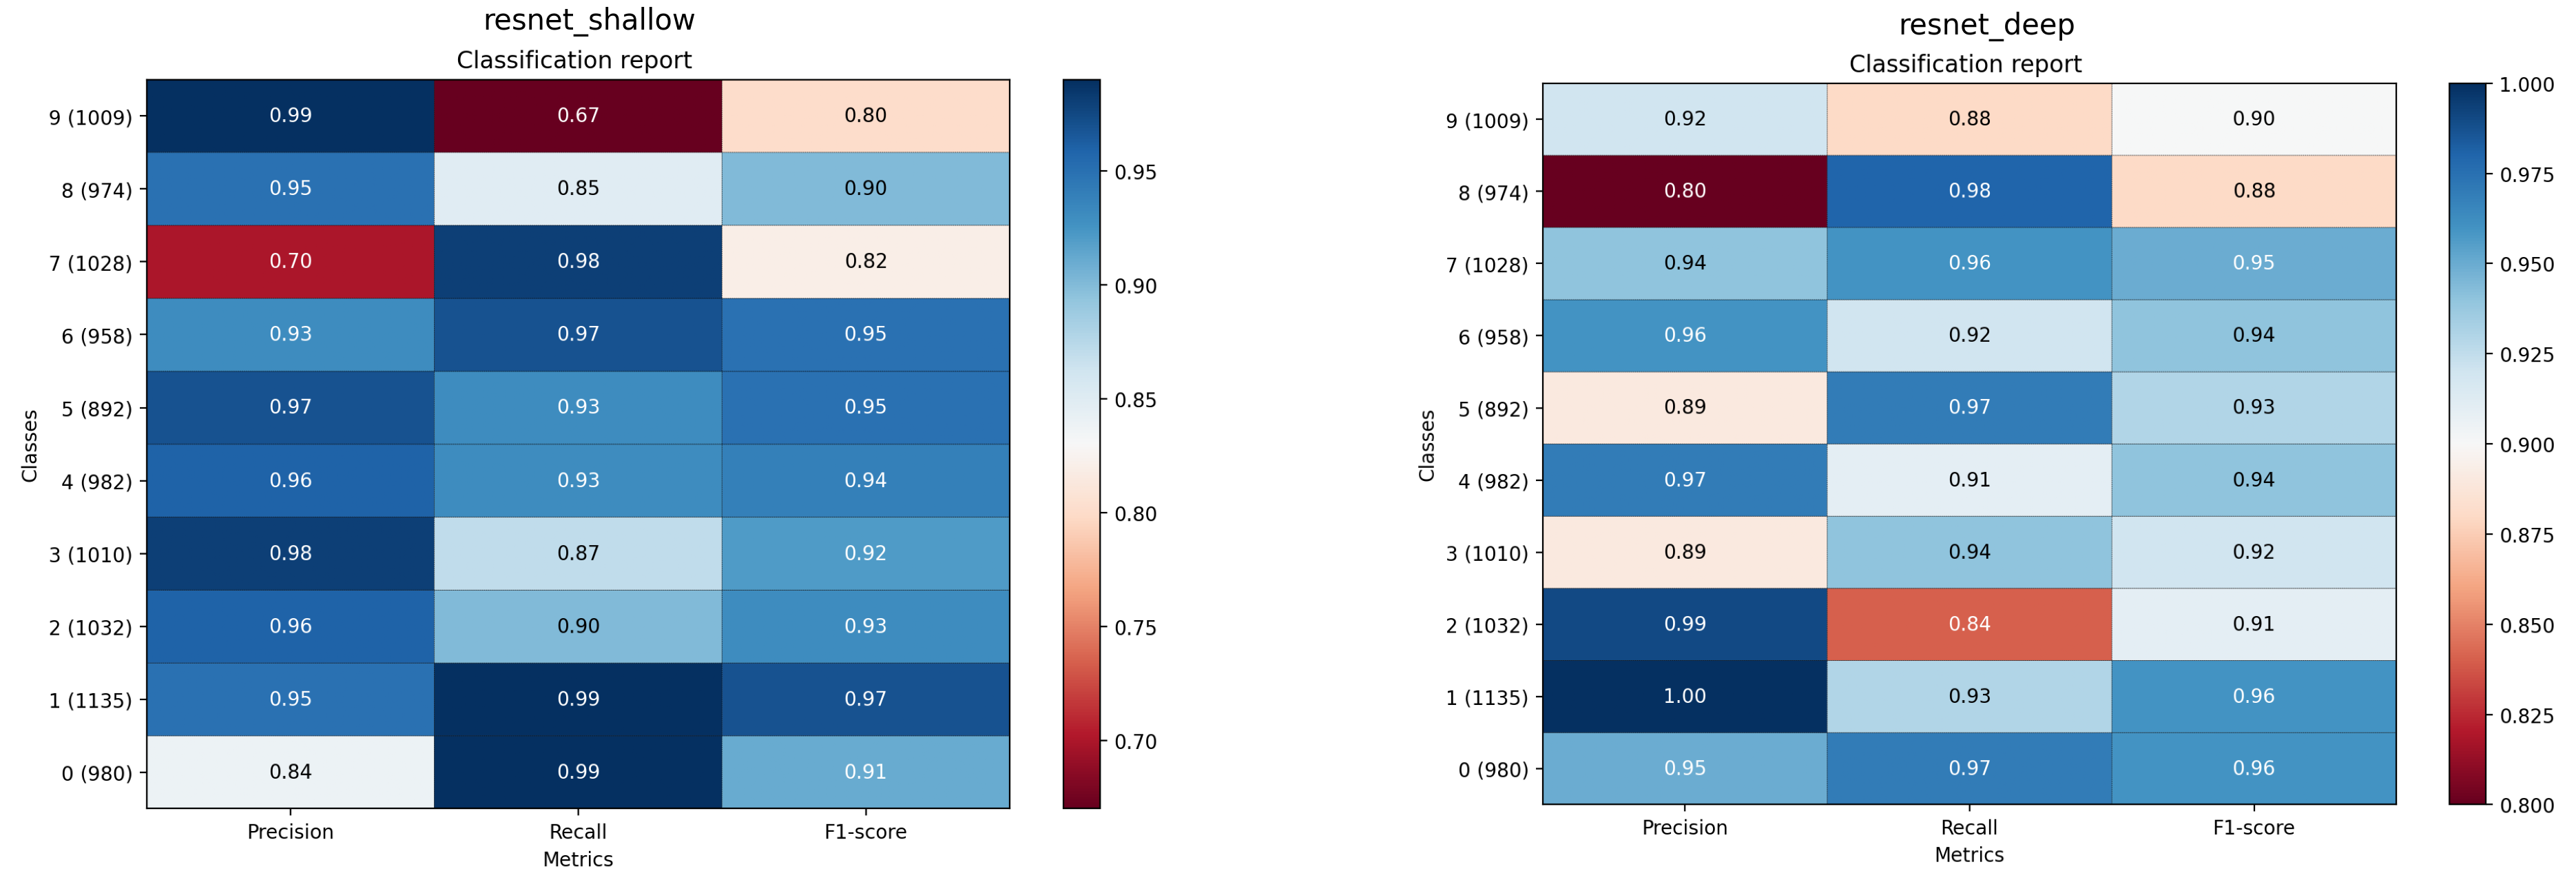

In [47]:
import matplotlib.pyplot as plt

# 读取左图表
left_image = plt.imread('./test_plot_classif_report.png')

# 读取右图表
right_image = plt.imread('./test_plot_classif_report_deep.png')

# 创建包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 24))

# 在左子图上绘制左图表
ax1.imshow(left_image)
ax1.set_title('resnet_shallow', fontsize=30)

# 在右子图上绘制右图表
ax2.imshow(right_image)
ax2.set_title('resnet_deep', fontsize=30)

# 调整子图之间的水平间距
fig.subplots_adjust(wspace=0.2)

# 移除每个子图周围的框线和坐标
for ax in [ax1, ax2]:
    ax.axis('off')

# 显示图表
plt.savefig('report_128.png')


In [48]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


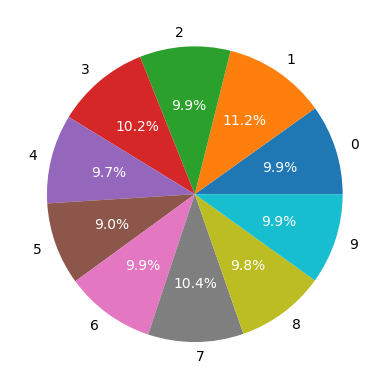

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# 给定的数组
data = y_train

# 统计每个数字出现的次数
counts = np.bincount(data)
print(counts)
# 计算每个数字出现的比例
proportions = counts / len(data)

# 创建扇形图
fig, ax = plt.subplots()

# 绘制扇形图
wedges, texts, autotexts = ax.pie(counts, labels=np.unique(data), autopct='%1.1f%%')

# 设置自动标签的格式
for autotext in autotexts:
    autotext.set_color('white')

# 设置图表标题
# ax.set_title("Occurrences and Proportions of Numbers in MNIST")

# 显示图表
plt.savefig('proportion.png')

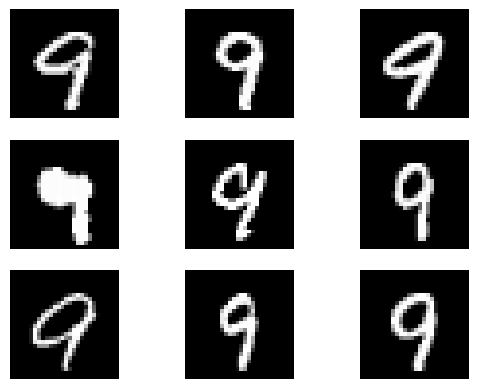

In [1]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt

# 加载MNIST数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 找到测试集中所有"7"的索引
indexes = [i for i, label in enumerate(y_test) if label == 9]

# 随机选择一些"7"进行展示
selected_indexes = np.random.choice(indexes, size=9, replace=False)

# 显示图片
for i, index in enumerate(selected_indexes):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()



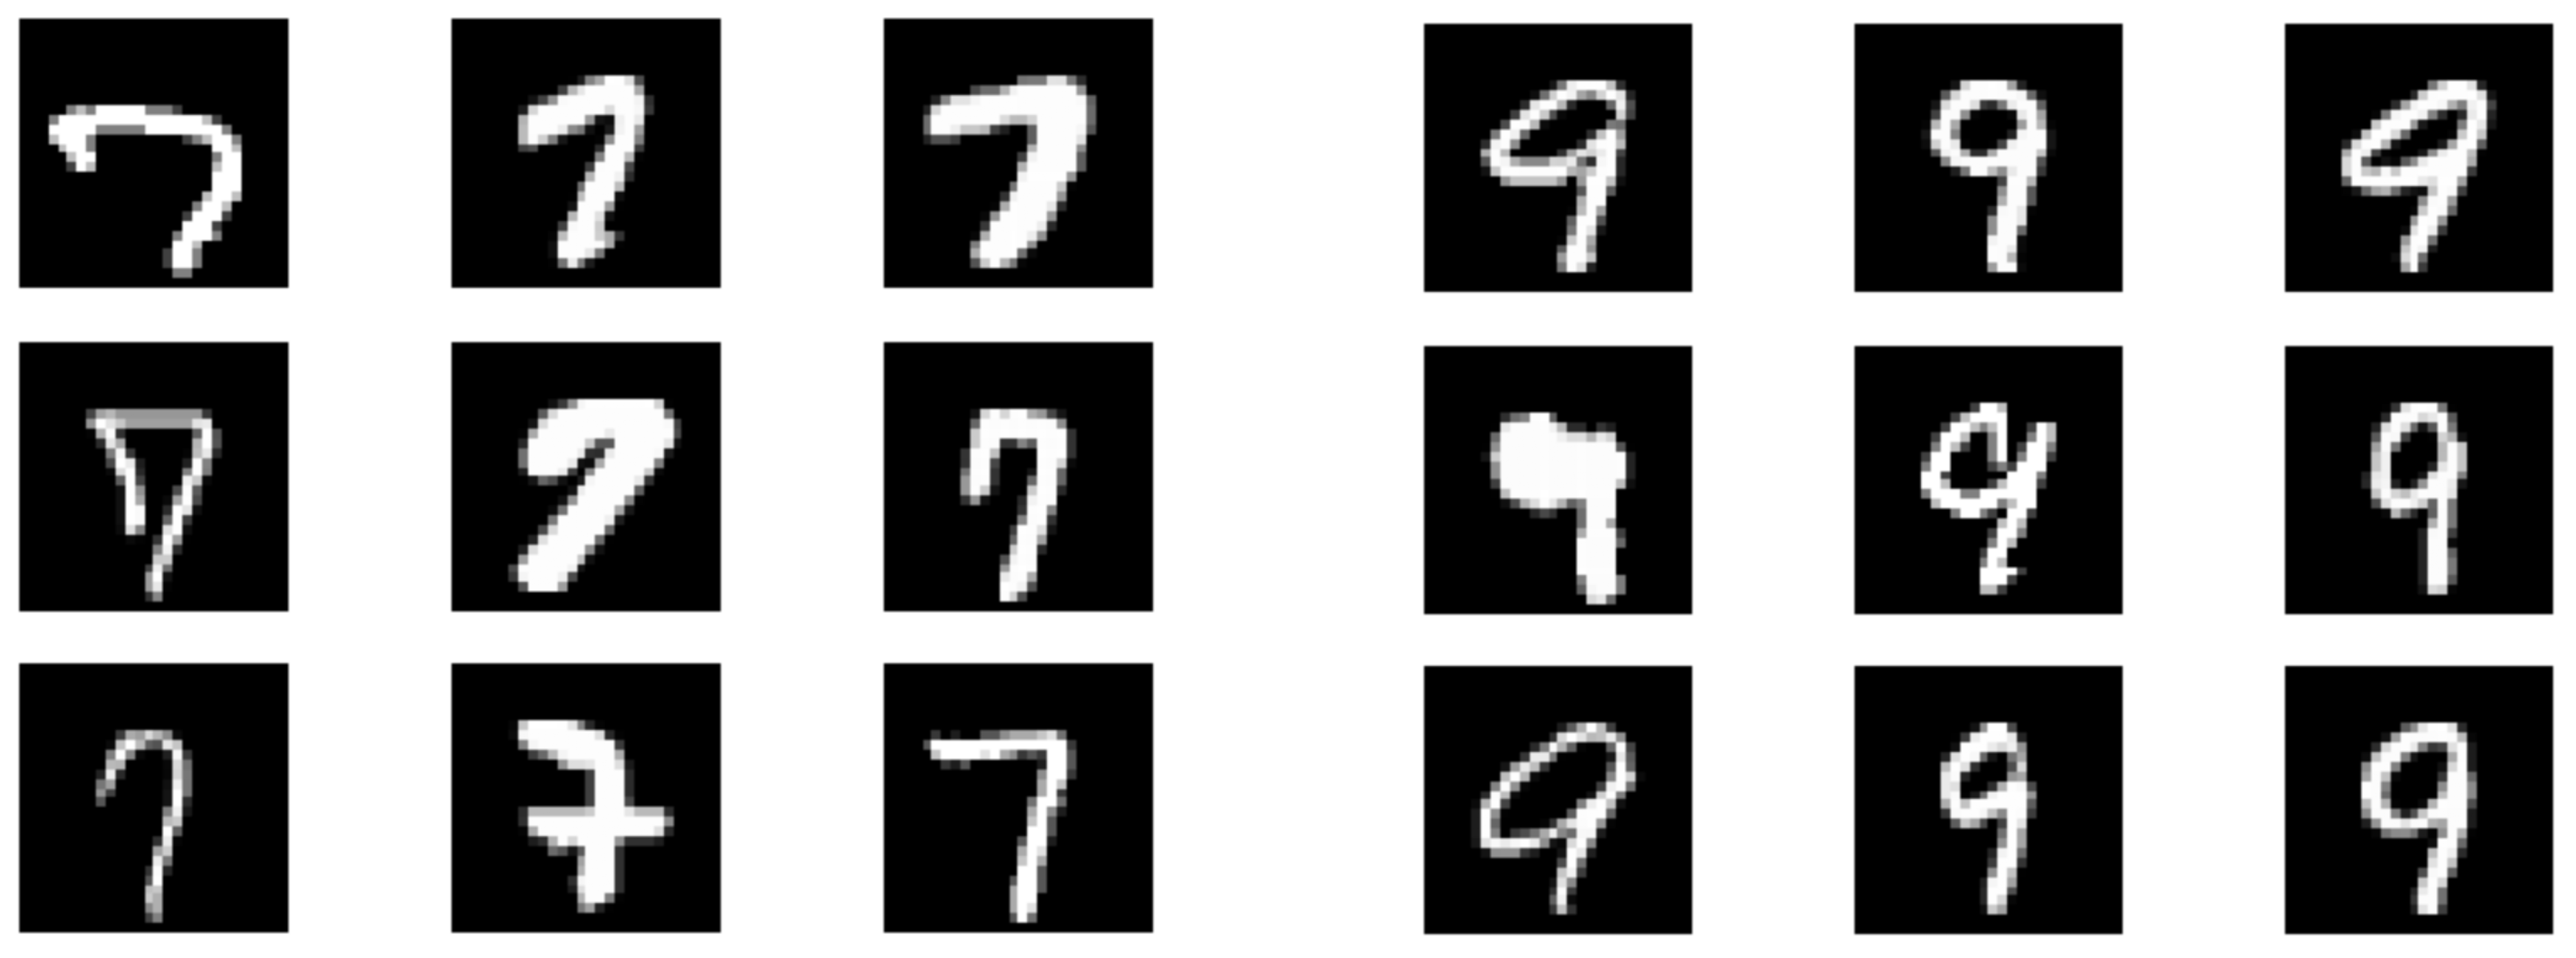

In [2]:
import matplotlib.pyplot as plt

# 读取左图表
left_image = plt.imread('./7.png')

# 读取右图表
right_image = plt.imread('./9.png')

# 创建包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(48, 24))

# 在左子图上绘制左图表
ax1.imshow(left_image)
# ax1.set_title('resnet_shallow', fontsize=30)

# 在右子图上绘制右图表
ax2.imshow(right_image)
# ax2.set_title('resnet_deep', fontsize=30)

# 调整子图之间的水平间距
fig.subplots_adjust(wspace=0.2)

# 移除每个子图周围的框线和坐标
for ax in [ax1, ax2]:
    ax.axis('off')

# 显示图表
plt.savefig('79.png')
